Andreu Gimenez Bolinches ([andreu@keio.jp](mailto:andreu@keio.jp))

# Problem

Find an optimal regulator of the following system in case 
$Q=diag(100, 100, 1, 1)$ and $g=9.8$ . Please set the value of each parameter
$m$, $M$ and $l$. You can use Matlab, Scilab, etc if necessary.

State equation:
$$\dot{x} = Ax + Bu$$

$$x = 
\left[\begin{matrix}x_1\\x_2\\x_3\\x_4\end{matrix}\right] =
\left[\begin{matrix}x\\\theta\\\dot{x}\\\dot{\theta}\end{matrix}\right]
$$

$$\left[\begin{matrix}\dot{x_1}\\\dot{x_2}\\\dot{x_3}\\\dot{x_4}\end{matrix}\right] =
\left[\begin{matrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\0 & - \frac{3 g m}{4 M + m}
& 0 & 0\\0 & \frac{g \left(3 M + 3 m\right)}{l \left(4 M + m\right)} & 0 &
0\end{matrix}\right]
\left[\begin{matrix}x_1\\x_2\\x_3\\x_4\end{matrix}\right]
+ 
\left[\begin{matrix}0\\0\\\frac{4}{4 M + m}\\- \frac{3}{l \left(4 M +
m\right)}\end{matrix}\right] u
$$

## Assumptions

If we consider $x$ to be a distance unit $[m]$ and $\theta$ an angle $[rad]$
then an analysis of the state space equation reveals that $m$ and $M$ must be
masses $[kg]$ and $l$ must be a distance $[m]$ while $u$ must be a force
$[kg*m/s^2]=[N]$

$$ m > 0 $$
$$ M > 0 $$
$$ l > 0 $$

## Approach

The problem has been solved using an interactive Python notebook, which has
been then converted into `pdf` as a report. One can find the source notebook in
the [code
repository](https://gitlab.com/jemaro/keio/intelligent-machine-system/3-optimal-regulator).

Initially we will import some general libraries and define the
[problem](#problem) system.

In [1]:
import numpy as np
import control as ct
from sympy import *

init_printing()

In [2]:
def system(m: float = 3, M: float = 10, l: float = 3, g: float = 9.8):
    A = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, (-3 * m * g) / (m + 4 * M), 0, 0],
        [0, 3 * (M + m) * g / ((m + 4 * M) * l), 0, 0],
        ])
    B = np.array([
        [0],
        [0],
        [4 / (m + 4 * M)],
        [-3 / ((m + 4 * M) * l)],
        ])
    C = np.array([[0, 1, 0, 0]])  # Output matrix
    D = np.zeros(shape=(C.shape[0], B.shape[1]))
    return ct.StateSpace(A, B, C, D)


# Optimal Control

In order to solve the [problem](#problem), we will follow the steps outlined in
lecture 6-16 to solve the optimal control problem with Riccati equation.

## Performance Index
The performance index that will be optimized is a quadratic cost function:
$$PI = \int_0^\infty \left(x^TQx+u^TPu\right)dt$$

## Riccati equation

$$A^TR + RA -RBP^{-1}B^TR + Q = 0$$ 

Python's scipy library provides a function to solve Riccati equation for $R$
given the rest of parameters ($A$, $B$, $Q$ and $P$). Everything is statet in
the [problem definition](#problem) except the parameter $P$, which we will
assume to be the identity matrix. We provide the solution for the same
selection of parameters $m$, $M$ and $l$ as in lecture 5 solution of the second
report assignement.

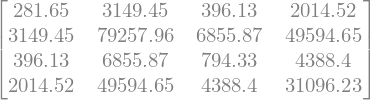

In [3]:
from scipy.linalg import solve_continuous_are as solve_riccati

m = 3
M = 10
l = 3
g = 9.8

A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, (-3 * m * g) / (m + 4 * M), 0, 0],
    [0, 3 * (M + m) * g / ((m + 4 * M) * l), 0, 0],
    ])
B = np.array([
    [0],
    [0],
    [4 / (m + 4 * M)],
    [-3 / ((m + 4 * M) * l)],
    ])
Q = np.diag([100, 100, 1, 1])
p = 1

R = solve_riccati(A, B, Q, p)
Matrix(np.round(R, 2))

## Optimal Control Input

After solving Riccati equation, one can calculate the optimal output as
follows:

$$u^o = -P^{-1}B^TRx$$
$$u^o = -Wx$$

We present here the numerical value of $W$ computed with the previous solution
of $R$.

In [4]:
W = p**(-1) * B.T @ R
Matrix(np.round(W, 2))


We also made the whole process of computing the optimal input a function in
order to run some simulations later. We print the resulting optimal output when the
system state is the following.

$$x_0 = 
\left[\begin{matrix}x_1\\x_2\\x_3\\x_4\end{matrix}\right] =
\left[\begin{matrix}x\\\theta\\\dot{x}\\\dot{\theta}\end{matrix}\right] =
\left[\begin{matrix}0\\0.1\\0\\0\end{matrix}\right]
$$

In [5]:
def uo(
        sys: ct.StateSpace,
        x: np.array,
        Q: np.array = np.diag([100, 100, 1, 1]),
        p: float = 1,
    ):
    R = solve_riccati(sys.A, sys.B, Q, p)
    W = p**(-1) * sys.B.T @ R
    return (-W @ x).item()  # Multiply matrices and output the scalar result


print(uo(system(), x=np.array([[0], [0.1], [0], [0]])))

51.56084942119076


## Simulation

We want to test if the computed optimal inputs do stabilize the system,
therefore we will simulate the system response over time. We gather the methods
shown previously and all the parameters in order to build a simulate function
that will allow us to test the response of the system even outside the problem
boundaries.

In [6]:
import matplotlib.pyplot as plt


def run_simulation(
    ax_x: plt.Axes,
    ax_u: plt.Axes,
    # Simulation configuration
    Tf: int = 50,
    dt: float = 0.05,
    # Initial position
    x0_x: float = 0,
    x0_theta: float = 0.1,
    x0_dx: float = 0,
    x0_dtheta: float = 0,
    # Performance Index
    Q_x: float = 100,
    Q_theta: float = 100,
    Q_dx: float = 1,
    Q_dtheta: float = 1,
    p: float = 1,
    # System parameters
    m: float = 3,
    M: float = 10,
    l: float = 3,
    g: float = 9.8,
    ):
    sys = system(m=m, M=M, l=l, g=g)  # Inverted pendulum on a cart
    nsteps = int(np.ceil(Tf / dt))  # Simulation steps
    x0 = np.array([[x0_x], [x0_theta], [x0_dx], [x0_dtheta]])  # Initial states
    Q = np.diag([Q_x, Q_theta, Q_dx, Q_dtheta])  # State performance matrix

    x = x0  # Array of states, rows as different time steps
    u = [None]  # List of inputs

    # Iterate over the simulation steps
    for k in range(nsteps):
        # Optimal input from the last state
        uo_ = uo(sys, x[:, -1], Q=Q, p=p)

        # Simulate one step of the system response with the optimal input
        _, _, x_ = ct.forced_response(
            sys, T=[0, dt], U=np.array([uo_, 0]), X0=x[:, -1], return_x=True
            )
        # Accumulate the states in an array and inputs in a list
        x = np.c_[x, x_[:, -1]]
        u.append(uo_)

    # Time array
    t = np.linspace(0, dt * nsteps, nsteps + 1)

    # Left plot
    ax_x.clear()
    ax_x.title.set_text('System State')
    ax_x.set_xlabel('Time [s]')
    ax_x.plot(t, x[0, :], label='$x$')
    ax_x.plot(t, x[1, :], label=r'$\theta$')
    ax_x.legend()

    # Right plot
    ax_u.clear()
    ax_u.title.set_text('Input $u^o$')
    ax_u.set_xlabel('Time [s]')
    ax_u.plot(t, u)


def simulate(**kwargs):
    fig, (ax_x, ax_u) = plt.subplots(1, 2)
    return run_simulation(ax_x=ax_x, ax_u=ax_u, **kwargs)

When the scenario presented in [the previous section](#optimal-control) is
simulated, one can see that the system stabilizes.

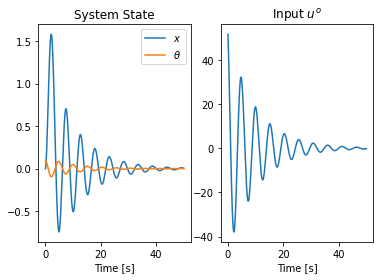

In [7]:
simulate(
    # System parameters
    m=3,
    M=10,
    l=3,
    g=9.8,
    # Initial state x1 = x, the rest is 0
    x0_theta=0.1,
    )


## Interactive

The simulation function can be put together with some notebook interactive
widgets in order to build a tool where the input parameters can be easily
manipulated.

In [ ]:
%matplotlib widget

In [ ]:
from ipywidgets import *

fig, (ax_x, ax_u) = plt.subplots(1, 2)

T = {
    'Tf':
        IntSlider(min=10, max=100, value=50, description='Duration [s]'),
    'dt':
        FloatSlider(
            min=0.01,
            max=0.3,
            value=0.05,
            step=0.01,
            description='Timestep [s]'
            ),
    }
x0 = {
    'x0_x':
        FloatSlider(min=-2, max=2, value=0, description=r'\(x\)'),
    'x0_theta':
        FloatSlider(min=-2, max=2, value=0.1, description=r'\(\theta\)'),
    'x0_dx':
        FloatSlider(min=-0.5, max=0.5, value=0, description=r'\(\dot{x}\)'),
    'x0_dtheta':
        FloatSlider(
            min=-0.5, max=0.5, value=0, description=r'\(\dot{\theta}\)'
            ),
    }
PI = {
    'Q_x':
        IntSlider(min=0, max=200, value=100, description=r'Q \(x\)'),
    'Q_theta':
        IntSlider(min=0, max=200, value=100, description=r'Q \(\theta\)'),
    'Q_dx':
        IntSlider(min=0, max=2, value=1, description=r'Q \(\dot{x}\)'),
    'Q_dtheta':
        IntSlider(min=0, max=2, value=1, description=r'Q \(\dot{\theta}\)'),
    }
sys = {
    'm': FloatSlider(min=0, max=10, value=3, description=r'\(m\)'),
    'M': FloatSlider(min=0, max=10, value=10, description=r'\(M\)'),
    'l': FloatSlider(min=0, max=10, value=3, description=r'\(l\)'),
    }

ui = GridBox(
    [
        VBox([Label('Configuration')] + [w for w in T.values()]),
        VBox([Label('Initial position')] + [w for w in x0.values()]),
        VBox([Label('Performance Index')] + [w for w in PI.values()]),
        VBox([Label('System')] + [w for w in sys.values()]),
        ],
    layout=Layout(grid_template_columns="repeat(2, 50%)"),
    )


def interactive_simulate(**kwargs):
    return run_simulation(ax_x=ax_x, ax_u=ax_u, **kwargs)


out = interactive_output(interactive_simulate, {**T, **x0, **PI, **sys})

display(ui, out)

Unfortunatelly, interactive cells are not rendered in the report, clone the [code
repository](https://gitlab.com/jemaro/keio/intelligent-machine-system/3-optimal-regulator)
in order to use it.

<!-- ![interactive](https://gitlab.com/jemaro/keio/intelligent-machine-system/3-optimal-regulator/-/raw/master/images/interactive.jpg) -->
![interactive](images/interactive.jpg)

This tool helps to find insights like the realization that if we remove the
term corresponding to the state $x$ from the $Q$ matrix, the [Performance
Index](#performance-index) will not penalize a non zero state $x$. Stabilizing
it in any value.

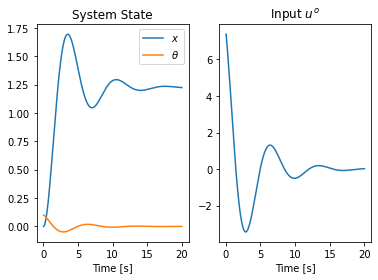

In [8]:
simulate(
    # Adjust the system to get a better looking plot
    M=3,
    m=0.5,
    l=0.3,
    Tf=20,
    # Ignore state "x" corresponding to "x1" in the Performance Index
    Q_x=0,
    )
